# 1. Set Up*

In [2]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import scipy.stats as st
import statistics as stats
import shap
import operator

In [18]:
# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, confusion_matrix, mean_squared_error, accuracy_score, classification_report, roc_curve, auc, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

from sklearn.feature_selection import RFECV

In [7]:
# Download latest version
path = kagglehub.dataset_download("prosperchuks/health-dataset")

Using Colab cache for faster access to the 'health-dataset' dataset.


In [8]:
csv_path = "/kaggle/input/health-dataset/diabetes_data.csv"
df_raw = pd.read_csv(csv_path)
df_raw.head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Exploratory Data Analysis

## Basic Check


No null values!

In [ ]:
print("Null values:", df_raw.isna().sum().sum())

print("\nDataset Info:")
df_raw.info()

Null values: 0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   70692 non-null  float64
 1   Sex                   70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  GenHlth               70692 non-null  float64
 12  MentHlth              70692 non-null  float64
 13  PhysHlth              70692 non-null  float64
 14  DiffWalk              70692 non-null  fl

## Demographics

No class imbalance

/tmp/ipython-input-3157704328.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y[i], y[i], ha='center')  # Aligning text at center


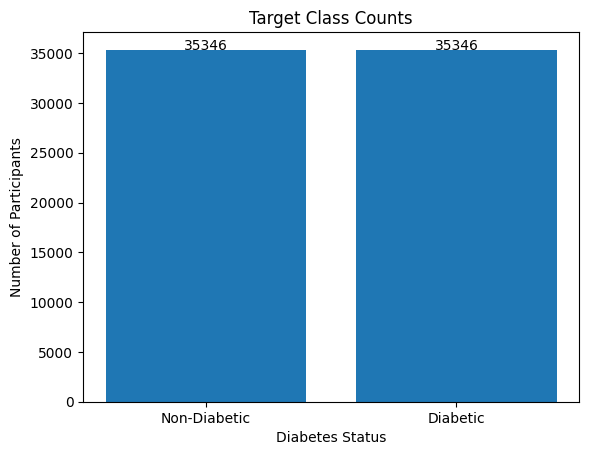

In [ ]:
# Target classes: Diabetic participants = 1, Non-diabetic participants = 0
target_freq = df_raw['Diabetes'].value_counts()
# Show distribution of feature correlation values with the target variable
target_labels = {0: "Non-Diabetic", 1: "Diabetic"}
target_freq.index = [target_labels[col] for col in target_freq.index]
plt.bar(target_freq.index, target_freq)
plt.xlabel("Diabetes Status")
plt.ylabel("Number of Participants")
plt.title(f"Target Class Counts")

def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha='center')  # Aligning text at center

# Adding value labels
add_labels(target_freq.index, target_freq)

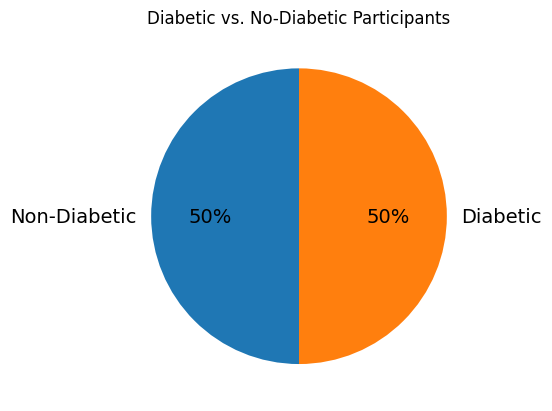

In [ ]:
# Diabetes classes: Male = 1, Female = 0
dib_freq = df_raw["Diabetes"].value_counts()

# Show distribution of feature correlation values with the target variable
dib_labels = {0: "Non-Diabetic", 1: "Diabetic"}
dib_freq.index = [dib_labels[col] for col in dib_freq.index]
plt.pie(dib_freq, labels=dib_freq.index, autopct='%1.0f%%', startangle=90, textprops={'fontsize': 14})
plt.title(f"Diabetic vs. No-Diabetic Participants")
plt.show()

More female participants than male, but mostly balanced.

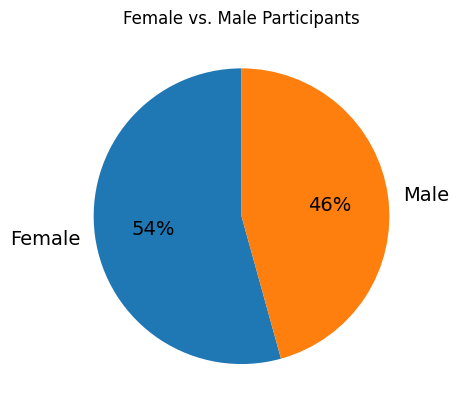

In [ ]:
# Sex attribute classes: Male = 1, Female = 0
sex_freq = df_raw["Sex"].value_counts()

# Show distribution of feature correlation values with the target variable
sex_labels = {0: "Female", 1: "Male"}
sex_freq.index = [sex_labels[col] for col in sex_freq.index]
plt.pie(sex_freq, labels=sex_freq.index, autopct='%1.0f%%', startangle=90, textprops={'fontsize': 14})
plt.title(f"Female vs. Male Participants")
plt.show()


*   More females in Non-Diabetic & Diabetic groups than males.
*   Diabetic males > non-diabetic maless
*   Diabetic females < non-diabetic females

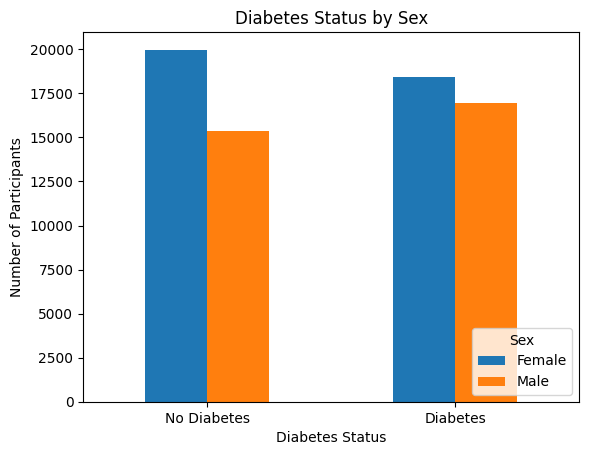

In [ ]:
male = df_raw[df_raw['Sex']==1]["Diabetes"]
female = df_raw[df_raw['Sex']==0]["Diabetes"]

grouped = pd.crosstab(df_raw['Diabetes'], df_raw['Sex'])
ax = grouped.plot(kind="bar")
ax.legend([sex_labels[col] for col in grouped.columns], title="Sex", loc=4)

# Map x-tick labels for Diabetes status
diabetes_labels = {0: "No Diabetes", 1: "Diabetes"}
ax.set_xticklabels([diabetes_labels[idx] for idx in grouped.index], rotation=0)

plt.title("Diabetes Status by Sex")
plt.xlabel("Diabetes Status")
plt.ylabel("Number of Participants")
plt.show()

Age Distribution of Dataset shows majority of participants are middle-aged to elderly.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]


Text(0.5, 1.0, 'Participant Age Distribution')

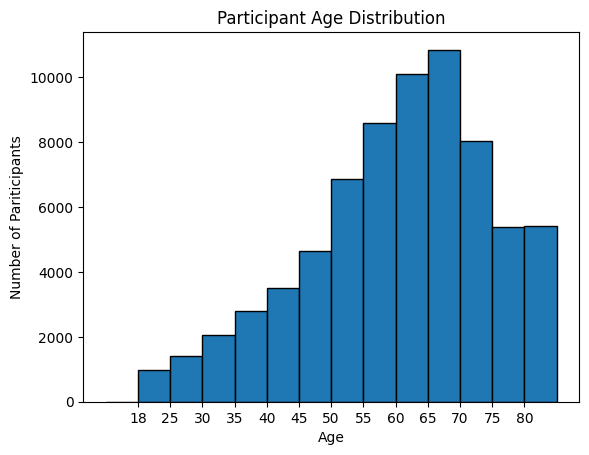

In [ ]:
age_freq = df_raw["Age"].value_counts().sort_index()
age_labels = [18] +[25+5*i for i in range(11)] + [80]

# show distribution of feature correlation values with the target variable
fig, ax = plt.subplots()
xRange = np.arange(1,14, step=1)
print(xRange)
print([age_labels[i-1] for i in xRange])
ax.set_xticks(xRange, [age_labels[i-1] for i in xRange])

plt.hist(df_raw["Age"], bins=range(15), edgecolor='black')

plt.xlabel("Age")
plt.ylabel("Number of Pariticipants")
plt.title("Participant Age Distribution")

BMI Distribution shows that 50% of the population has a BMI between 25-35

q1 25.0 median 29.0 q3 33.0


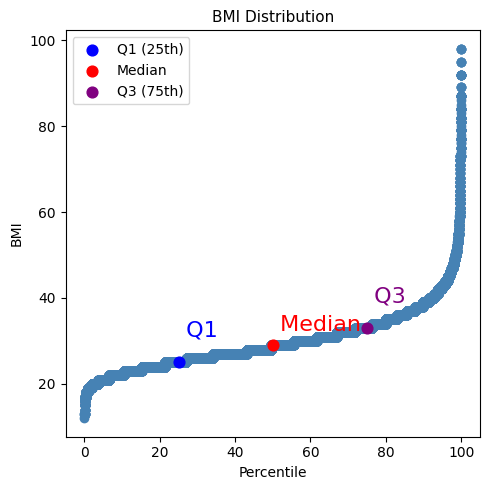

In [ ]:
feature = 'BMI'

# Split the groups
bmi = df_raw[feature].dropna().sort_values()

# Calculate summary stats
median_bmi = bmi.median()
q1_bmi = np.percentile(bmi, 25)
q3_bmi = np.percentile(bmi, 75)
print("q1", q1_bmi, "median", median_bmi, "q3", q3_bmi)

# Generate percentiles (0 to 100)
percentiles = np.linspace(0, 100, len(bmi))
bmi_values = np.percentile(bmi, percentiles)

# Plot
plt.figure(figsize=(5,5))
plt.scatter(percentiles, bmi_values, color="#4682B4")

plt.scatter(25, q1_bmi, color='blue', s=60, label='Q1 (25th)')
plt.scatter(50, median_bmi, color='red', s=60, label='Median')
plt.scatter(75, q3_bmi, color='purple', s=60, label='Q3 (75th)')

plt.text(25, q1_bmi+5, ' Q1', va='bottom', ha='left', fontsize=16, color='blue')
plt.text(50, median_bmi+7, ' Median', va='top', ha='left', fontsize=16, color='red')
plt.text(75, q3_bmi+5, ' Q3', va='bottom', ha='left', fontsize=16, color='purple')

plt.title("BMI Distribution", fontsize=11)
plt.xlabel("Percentile")
plt.ylabel("BMI")
plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of BMI')

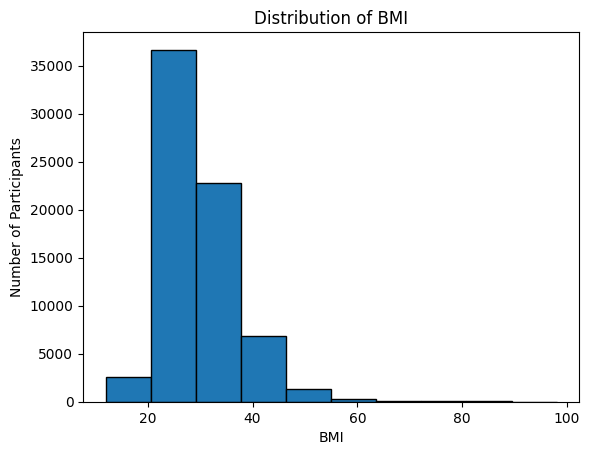

In [ ]:
# show distribution of BMI
plt.hist(df_raw['BMI'], bins=10, edgecolor='black')
plt.xlabel("BMI")
plt.ylabel("Number of Participants")
plt.title(f"Distribution of BMI")

### Sex Feature Comparisons

Age Comparison


*   Males tend to have be older


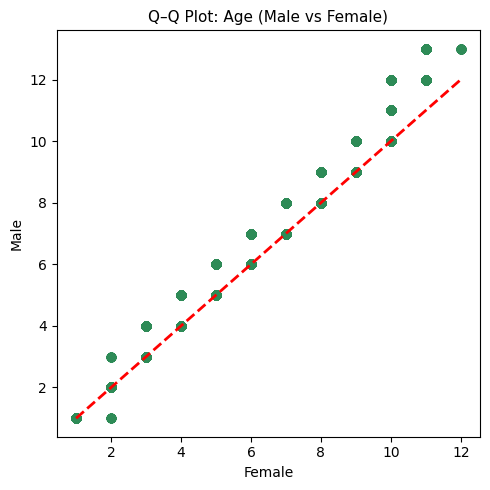

In [ ]:
feature = 'Age'
male = df_raw[df_raw['Sex']==1][feature].dropna().sort_values()
female = df_raw[df_raw['Sex']==0][feature].dropna().sort_values()

n = min(len(male), len(female))
male = male.iloc[:n]
female = female.iloc[:n]

plt.figure(figsize=(5,5))
plt.scatter(female, male, alpha=0.6, color="#2E8B57")
plt.plot([female.min(), female.max()],
         [female.min(), female.max()],
         'r--', lw=2)
plt.title("Q–Q Plot: Age (Male vs Female)", fontsize=11)
plt.xlabel("Female")
plt.ylabel("Male")
plt.tight_layout()
plt.show()

BMI Comparison


* males show higher BMI
* skew likely because males have greater muscle mass
*  BMI does not distinguish between muscle & fat

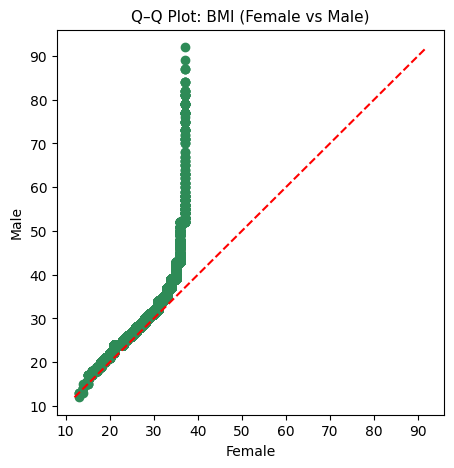

In [ ]:
feature = 'BMI'
male = df_raw[df_raw['Sex']==1][feature].dropna().sort_values()
female = df_raw[df_raw['Sex']==0][feature].dropna().sort_values()

n = min(len(male), len(female))
male = male.iloc[:n]
female = female.iloc[:n]

plt.figure(figsize=(5,5))
plt.scatter(female, male, color="#2E8B57")
plt.plot([male.min(), male.max()],
         [male.min(), male.max()],
         'r--')
plt.title("Q–Q Plot: BMI (Female vs Male)", fontsize=11)
plt.xlabel("Female")
plt.ylabel("Male")
plt.show()

Mental Health
* Males tend to have much worse mental health than females

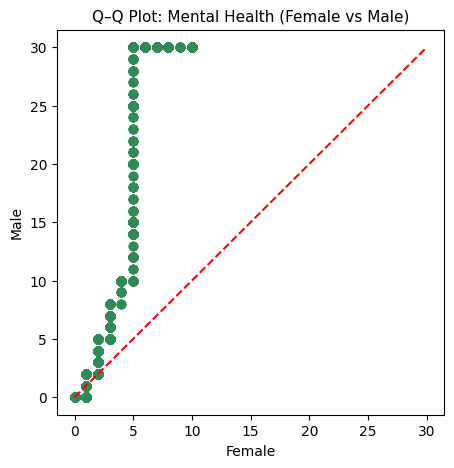

In [ ]:
feature = 'MentHlth'
male = df_raw[df_raw['Sex']==1][feature].dropna().sort_values()
female = df_raw[df_raw['Sex']==0][feature].dropna().sort_values()

n = min(len(male), len(female))
male = male.iloc[:n]
female = female.iloc[:n]

plt.figure(figsize=(5,5))
plt.scatter(female, male, color="#2E8B57")
plt.plot([male.min(), male.max()],
         [male.min(), male.max()],
         'r--')
plt.title("Q–Q Plot: Mental Health (Female vs Male)", fontsize=11)
plt.xlabel("Female")
plt.ylabel("Male")
plt.show()

Physical Health
* Males tend to be less healthy

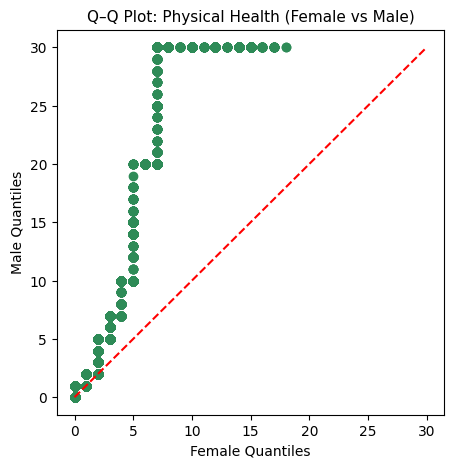

In [ ]:
feature = 'PhysHlth'
male = df_raw[df_raw['Sex']==1][feature].dropna().sort_values()
female = df_raw[df_raw['Sex']==0][feature].dropna().sort_values()

n = min(len(male), len(female))
male = male.iloc[:n]
female = female.iloc[:n]

plt.figure(figsize=(5,5))
plt.scatter(female, male, color="#2E8B57")
plt.plot([male.min(), male.max()],
         [male.min(), male.max()],
         'r--')
plt.title("Q–Q Plot: Physical Health (Female vs Male)", fontsize=11)
plt.xlabel("Female Quantiles")
plt.ylabel("Male Quantiles")
plt.show()

General Health in Males vs. Female
* Similar distribution

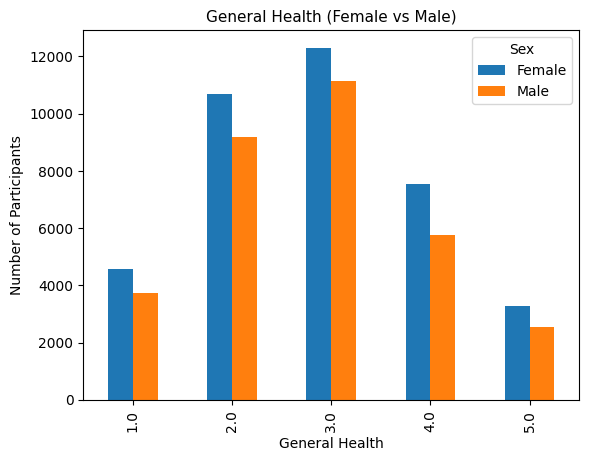

In [ ]:
# 1 <- good, 5 <- worse
feature = 'GenHlth'
male = df_raw[df_raw['Sex']==1][feature].dropna().sort_values()
female = df_raw[df_raw['Sex']==0][feature].dropna().sort_values()

grouped = pd.crosstab(df_raw['GenHlth'], df_raw['Sex'])
grouped.plot(kind="bar")
plt.legend([sex_labels[col] for col in grouped.columns], title="Sex")
plt.title("General Health (Female vs Male)", fontsize=11)
plt.xlabel("General Health Rating")
plt.ylabel("Number of Participants")
plt.show()


## Diabetic vs. Non-Diabetic

Diabetic vs non-diabetic distributions for BMI

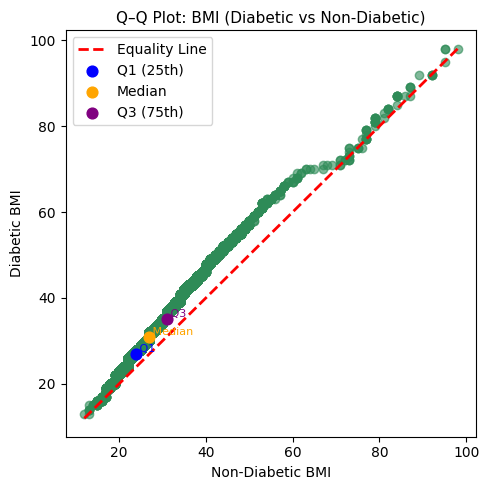

In [ ]:
feature = 'BMI'

# Split groups
diabetic = df_raw[df_raw['Diabetes']==1][feature].dropna().sort_values()
nondiabetic = df_raw[df_raw['Diabetes']==0][feature].dropna().sort_values()

# Equalize sample sizes
n = min(len(diabetic), len(nondiabetic))
diabetic = diabetic.iloc[:n]
nondiabetic = nondiabetic.iloc[:n]

# Calculate summary stats
median_diab, median_non = diabetic.median(), nondiabetic.median()
q1_diab, q1_non = np.percentile(diabetic, 25), np.percentile(nondiabetic, 25)
q3_diab, q3_non = np.percentile(diabetic, 75), np.percentile(nondiabetic, 75)

# Q–Q Plot
plt.figure(figsize=(5,5))
plt.scatter(nondiabetic, diabetic, alpha=0.6, color="#2E8B57")
plt.plot([nondiabetic.min(), nondiabetic.max()],
         [nondiabetic.min(), nondiabetic.max()],
         'r--', lw=2, label='Equality Line')

# Mark Q1, Median, and Q3
plt.scatter(q1_non, q1_diab, color='blue', s=60, label='Q1 (25th)')
plt.scatter(median_non, median_diab, color='orange', s=60, label='Median')
plt.scatter(q3_non, q3_diab, color='purple', s=60, label='Q3 (75th)')

# Annotate markers
plt.text(q1_non, q1_diab, ' Q1', va='bottom', ha='left', fontsize=8, color='blue')
plt.text(median_non, median_diab, ' Median', va='bottom', ha='left', fontsize=8, color='orange')
plt.text(q3_non, q3_diab, ' Q3', va='bottom', ha='left', fontsize=8, color='purple')

# Labels and legend
plt.title(f"Q–Q Plot: {feature} (Diabetic vs Non-Diabetic)", fontsize=11)
plt.xlabel("Non-Diabetic BMI")
plt.ylabel("Diabetic BMI")
plt.legend()
plt.tight_layout()
plt.show()


Diabetic vs non-diabetic distributions for Age

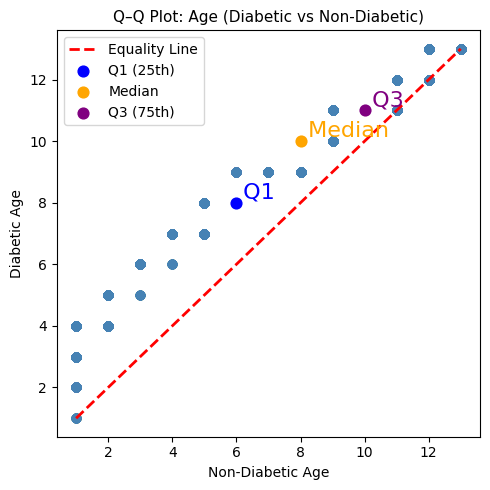

In [ ]:
feature = 'Age'

# Split the groups
diabetic = df_raw[df_raw['Diabetes']==1][feature].dropna().sort_values()
nondiabetic = df_raw[df_raw['Diabetes']==0][feature].dropna().sort_values()

# Equalize lengths
n = min(len(diabetic), len(nondiabetic))
diabetic = diabetic.iloc[:n]
nondiabetic = nondiabetic.iloc[:n]

# Calculate summary stats
median_diab, median_non = diabetic.median(), nondiabetic.median()
q1_diab, q1_non = np.percentile(diabetic, 25), np.percentile(nondiabetic, 25)
q3_diab, q3_non = np.percentile(diabetic, 75), np.percentile(nondiabetic, 75)

# Plot
plt.figure(figsize=(5,5))
plt.scatter(nondiabetic, diabetic, alpha=0.6, color="#4682B4")
plt.plot([nondiabetic.min(), nondiabetic.max()],
         [nondiabetic.min(), nondiabetic.max()],
         'r--', lw=2, label='Equality Line')

plt.scatter(q1_non, q1_diab, color='blue', s=60, label='Q1 (25th)')
plt.scatter(median_non, median_diab, color='orange', s=60, label='Median')
plt.scatter(q3_non, q3_diab, color='purple', s=60, label='Q3 (75th)')

plt.text(q1_non, q1_diab, ' Q1', va='bottom', ha='left', fontsize=16, color='blue')
plt.text(median_non, median_diab, ' Median', va='bottom', ha='left', fontsize=16, color='orange')
plt.text(q3_non, q3_diab, ' Q3', va='bottom', ha='left', fontsize=16, color='purple')

plt.title("Q–Q Plot: Age (Diabetic vs Non-Diabetic)", fontsize=11)
plt.xlabel("Non-Diabetic Age")
plt.ylabel("Diabetic Age")
plt.legend()
plt.tight_layout()
plt.show()


Diabetic vs non-diabetic distributions for PhysHlth

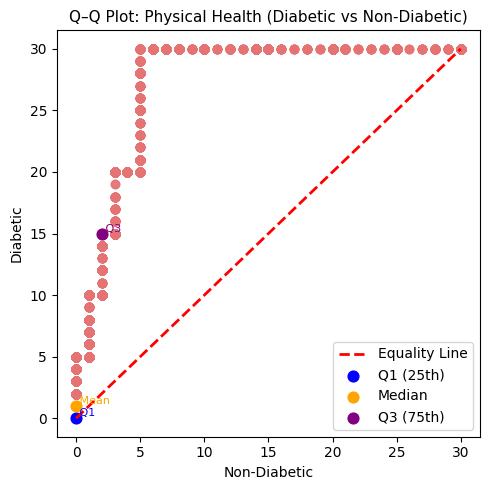

In [ ]:
feature = 'PhysHlth'

diabetic = df_raw[df_raw['Diabetes']==1][feature].dropna().sort_values()
nondiabetic = df_raw[df_raw['Diabetes']==0][feature].dropna().sort_values()

n = min(len(diabetic), len(nondiabetic))
diabetic = diabetic.iloc[:n]
nondiabetic = nondiabetic.iloc[:n]

median_diab, median_non = diabetic.median(), nondiabetic.median()
q1_diab, q1_non = np.percentile(diabetic, 25), np.percentile(nondiabetic, 25)
q3_diab, q3_non = np.percentile(diabetic, 75), np.percentile(nondiabetic, 75)

plt.figure(figsize=(5,5))
plt.scatter(nondiabetic, diabetic, alpha=0.6, color="#E57373")
plt.plot([nondiabetic.min(), nondiabetic.max()],
         [nondiabetic.min(), nondiabetic.max()],
         'r--', lw=2, label='Equality Line')

plt.scatter(q1_non, q1_diab, color='blue', s=60, label='Q1 (25th)')
plt.scatter(median_non, median_diab, color='orange', s=60, label='Median')
plt.scatter(q3_non, q3_diab, color='purple', s=60, label='Q3 (75th)')

plt.text(q1_non, q1_diab, ' Q1', va='bottom', ha='left', fontsize=8, color='blue')
plt.text(median_non, median_diab, ' Mean', va='bottom', ha='left', fontsize=8, color='orange')
plt.text(q3_non, q3_diab, ' Q3', va='bottom', ha='left', fontsize=8, color='purple')

plt.title("Q–Q Plot: Physical Health (Diabetic vs Non-Diabetic)", fontsize=11)
plt.xlabel("Non-Diabetic")
plt.ylabel("Diabetic")
plt.legend()
plt.tight_layout()
plt.show()


Diabetic vs non-diabetic distributions for MentHlth

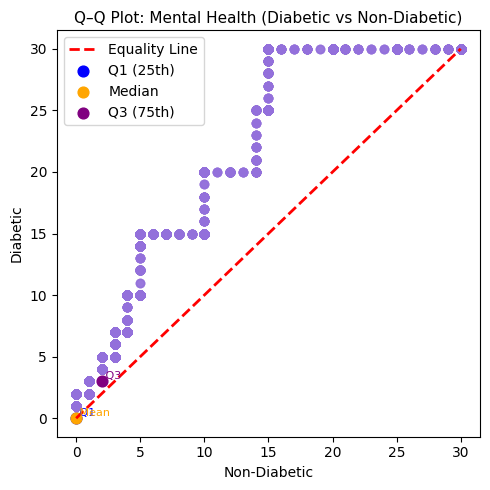

In [ ]:
feature = 'MentHlth'

diabetic = df_raw[df_raw['Diabetes']==1][feature].dropna().sort_values()
nondiabetic = df_raw[df_raw['Diabetes']==0][feature].dropna().sort_values()

n = min(len(diabetic), len(nondiabetic))
diabetic = diabetic.iloc[:n]
nondiabetic = nondiabetic.iloc[:n]

median_diab, median_non = diabetic.median(), nondiabetic.median()
q1_diab, q1_non = np.percentile(diabetic, 25), np.percentile(nondiabetic, 25)
q3_diab, q3_non = np.percentile(diabetic, 75), np.percentile(nondiabetic, 75)

plt.figure(figsize=(5,5))
plt.scatter(nondiabetic, diabetic, alpha=0.6, color="#9370DB")
plt.plot([nondiabetic.min(), nondiabetic.max()],
         [nondiabetic.min(), nondiabetic.max()],
         'r--', lw=2, label='Equality Line')

plt.scatter(q1_non, q1_diab, color='blue', s=60, label='Q1 (25th)')
plt.scatter(median_non, median_diab, color='orange', s=60, label='Median')
plt.scatter(q3_non, q3_diab, color='purple', s=60, label='Q3 (75th)')

plt.text(q1_non, q1_diab, ' Q1', va='bottom', ha='left', fontsize=8, color='blue')
plt.text(median_non, median_diab, ' Mean', va='bottom', ha='left', fontsize=8, color='orange')
plt.text(q3_non, q3_diab, ' Q3', va='bottom', ha='left', fontsize=8, color='purple')

plt.title("Q–Q Plot: Mental Health (Diabetic vs Non-Diabetic)", fontsize=11)
plt.xlabel("Non-Diabetic")
plt.ylabel("Diabetic")
plt.legend()
plt.tight_layout()
plt.show()


Scatter Plot: BMI vs. Age  

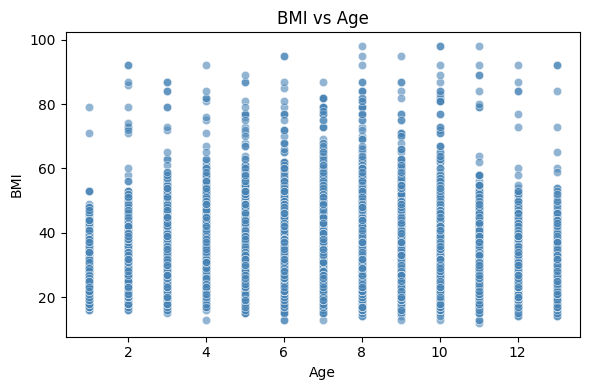

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='Age', y='BMI', data=df_raw, alpha=0.6, color='#4682B4')

plt.title("BMI vs Age", fontsize=12)
plt.xlabel("Age")
plt.ylabel("BMI")
plt.tight_layout()
plt.show()


Text(24.624999999999993, 0.5, 'BMI')

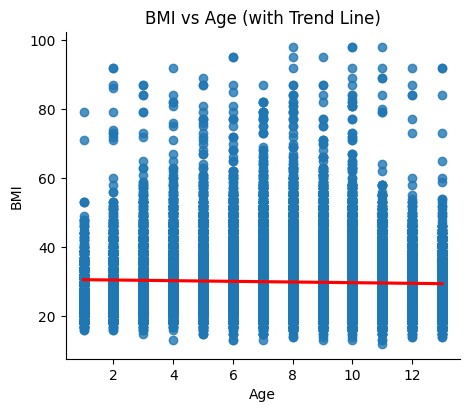

In [ ]:
sns.lmplot(x='Age', y='BMI', data=df_raw, height=4, aspect=1.2, line_kws={'color':'red'})
plt.title("BMI vs Age (with Trend Line)")
plt.xlabel("Age")
plt.ylabel("BMI")

Scatter Plot: Age vs Physical Health

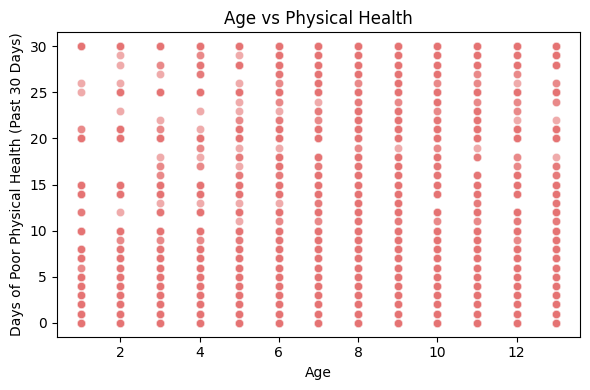

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='Age', y='PhysHlth', data=df_raw, alpha=0.6, color='#E57373')

plt.title("Age vs Physical Health", fontsize=12)
plt.xlabel("Age")
plt.ylabel("Days of Poor Physical Health (Past 30 Days)")
plt.tight_layout()
plt.show()


Text(33.37499999999999, 0.5, 'Days of Poor Physical Health (Past 30 Days)')

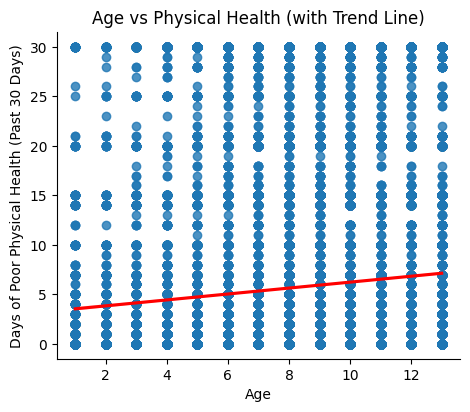

In [ ]:
sns.lmplot(x='Age', y='PhysHlth', data=df_raw, height=4, aspect=1.2, line_kws={'color':'red'})
plt.title("Age vs Physical Health (with Trend Line)")
plt.xlabel("Age")
plt.ylabel("Days of Poor Physical Health (Past 30 Days)")


Looking at the ratio of binary features between diabetic and non-diabetic participants

<Figure size 800x600 with 0 Axes>

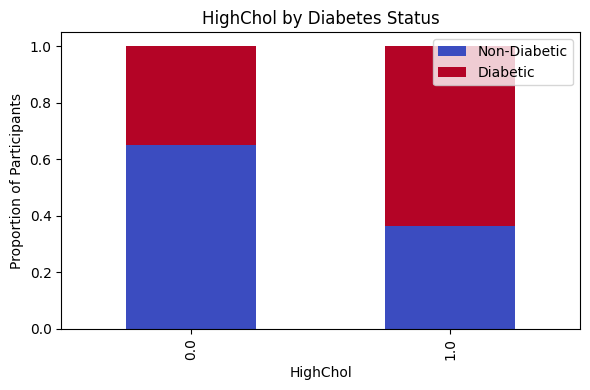

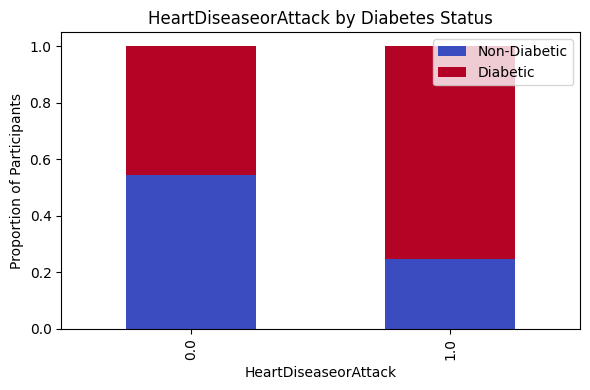

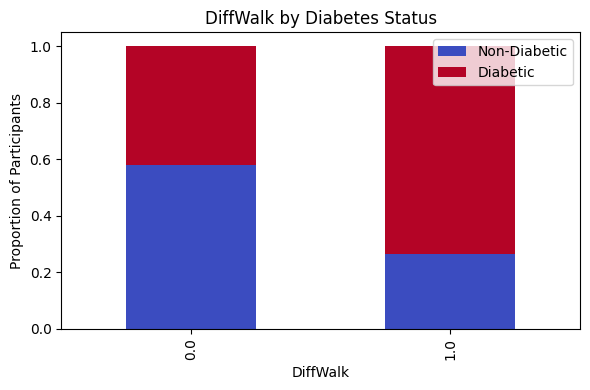

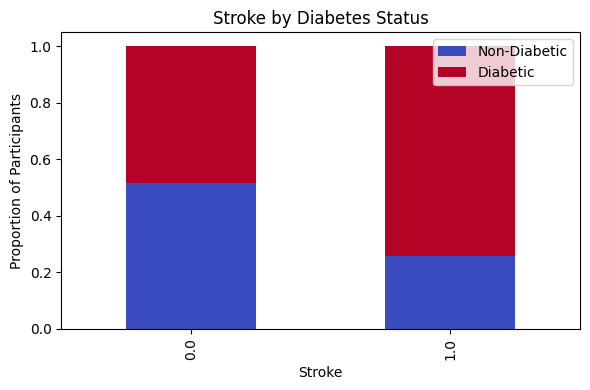

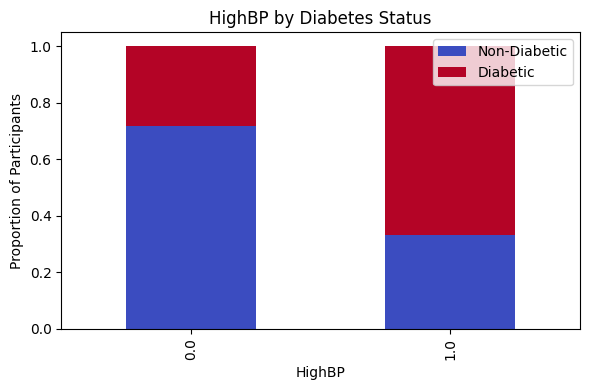

In [ ]:
# Selected binary features to visualize
selected_features = [
    'HighChol',
    'HeartDiseaseorAttack',
    'DiffWalk',
    'Stroke',
    'HighBP'
]

plt.figure(figsize=(8,6))
for feature in selected_features:
    # Create a normalized cross-tab (proportion of diabetics vs non-diabetics)
    crosstab = pd.crosstab(df_raw[feature], df_raw['Diabetes'], normalize='index')

    # Plot stacked bar chart
    crosstab.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(6,4))
    plt.title(f"{feature} by Diabetes Status", fontsize=12)
    plt.xlabel(feature)
    plt.ylabel("Proportion of Participants")
    plt.legend(['Non-Diabetic', 'Diabetic'])
    plt.tight_layout()
    plt.show()


<Figure size 900x600 with 0 Axes>

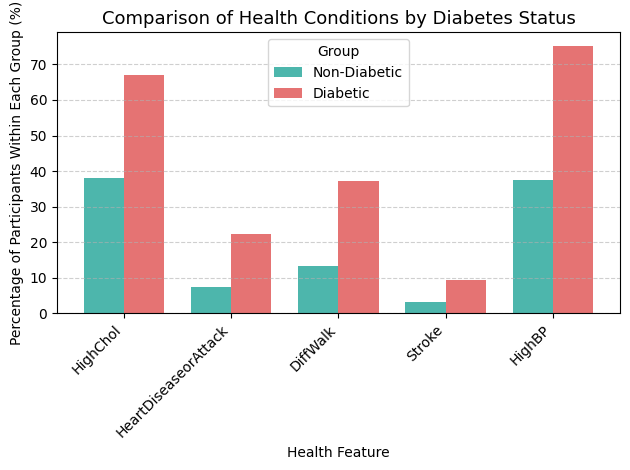

In [ ]:
# Selected binary features
features = ['HighChol', 'HeartDiseaseorAttack',
            'DiffWalk', 'Stroke', 'HighBP']

# Calculate proportions (median of each binary variable for both diabetic groups)
binary_means = df_raw.groupby('Diabetes')[features].mean().T * 100
binary_means.columns = ['Non-Diabetic', 'Diabetic']

# Plot grouped bar chart
plt.figure(figsize=(9,6))
binary_means.plot(kind='bar', width=0.75, color=['#4DB6AC', '#E57373'])

plt.title('Comparison of Health Conditions by Diabetes Status', fontsize=13)
plt.ylabel('Percentage of Participants Within Each Group (%)')
plt.xlabel('Health Feature')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# 3. Feature Correlation & Selection

### Binary Variables Only

In [ ]:
binary_features = [col for col in df_raw.columns if df_raw[col].nunique() == 2 and col != 'Diabetes']

results = []

for feature in binary_features:
    # Contingency table
    table = pd.crosstab(df_raw[feature], df_raw['Diabetes'])

    # Chi-square test
    chi2, p_chi, _, _ = st.chi2_contingency(table)

    # Phi coefficient (Pearson correlation for binary)
    result = st.pearsonr(df_raw[feature], df_raw['Diabetes'])
    phi = abs(st.pearsonr(df_raw[feature], df_raw['Diabetes'])[0])
    p_phi = st.pearsonr(df_raw[feature], df_raw['Diabetes'])[1]

    results.append({
        'Feature': feature,
        'Chi2 p-value': p_chi,
        'Phi Coefficient': phi,
        'Phi p-value': p_phi
    })

# Convert to DataFrame for easy viewing
correlation_df = pd.DataFrame(results).sort_values(by='Phi Coefficient', key=abs, ascending=False)
print(correlation_df)

                 Feature   Chi2 p-value  Phi Coefficient    Phi p-value
11                HighBP   0.000000e+00         0.381516   0.000000e+00
1               HighChol   0.000000e+00         0.289213   0.000000e+00
9               DiffWalk   0.000000e+00         0.272646   0.000000e+00
4   HeartDiseaseorAttack   0.000000e+00         0.211523   0.000000e+00
5           PhysActivity   0.000000e+00         0.158666   0.000000e+00
10                Stroke  1.290837e-243         0.125427  9.382035e-246
2              CholCheck  2.379871e-206         0.115382  4.864796e-208
8      HvyAlcoholConsump  3.913396e-140         0.094853  5.854501e-141
3                 Smoker  1.221105e-115         0.085999  3.918885e-116
7                Veggies   1.400710e-98         0.079293   5.752654e-99
6                 Fruits   7.967065e-47         0.054077   6.143416e-47
0                    Sex   3.860396e-32         0.044413   3.300778e-32


                        Sex  HighChol  CholCheck  Smoker  \
Sex                   1.000     0.017      0.008   0.112   
HighChol              0.017     1.000      0.086   0.093   
CholCheck             0.008     0.086      1.000   0.004   
Smoker                0.112     0.093      0.004   1.000   
HeartDiseaseorAttack  0.098     0.181      0.043   0.124   
PhysActivity          0.052     0.090      0.008   0.080   
Fruits                0.089     0.047      0.017   0.075   
Veggies               0.053     0.043      0.000   0.030   
HvyAlcoholConsump     0.014     0.025      0.027   0.078   
DiffWalk              0.082     0.162      0.044   0.120   
Stroke                0.004     0.100      0.023   0.065   
HighBP                0.041     0.317      0.103   0.087   

                      HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  \
Sex                                  0.098         0.052   0.089    0.053   
HighChol                             0.181         0.090   0.047 

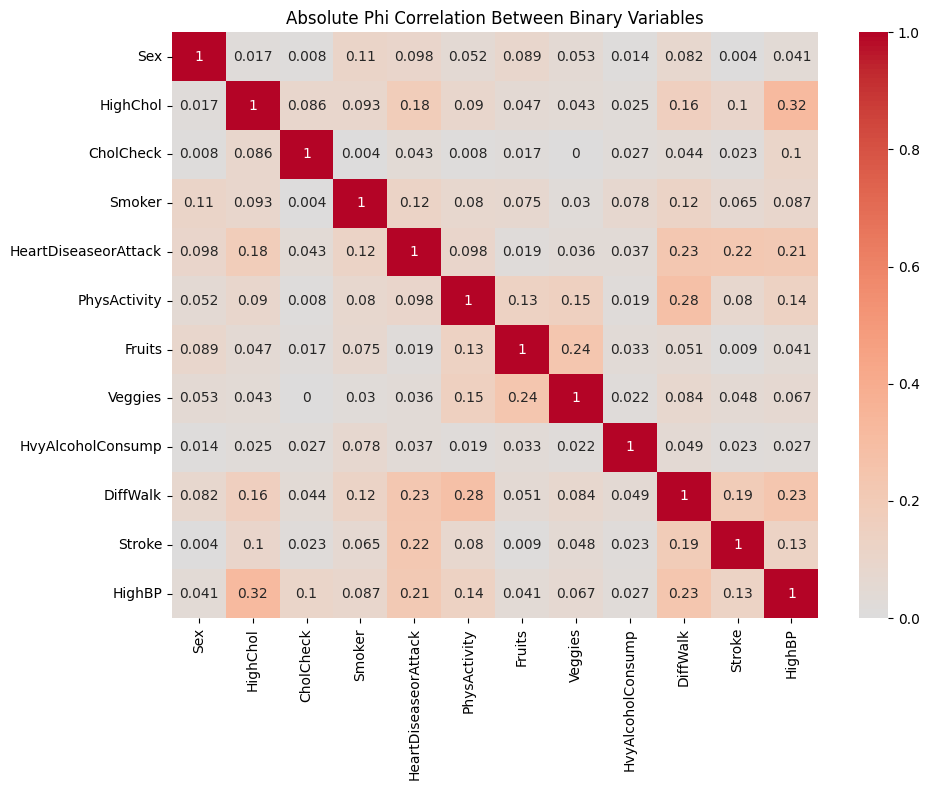

In [ ]:
# Create empty correlation matrix
corr_matrix = pd.DataFrame(index=binary_features, columns=binary_features)

# Fill matrix with Phi coefficients
for col1 in binary_features:
    for col2 in binary_features:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        else:
            r = abs(st.pearsonr(df_raw[col1], df_raw[col2])[0])
            corr_matrix.loc[col1, col2] = round(r, 3)

# Convert to float for plotting
corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Absolute Phi Correlation Between Binary Variables")
plt.tight_layout()
plt.show()

### All Variables

Helper Methods for calculating cross-type variables

Find feature correlation values with Diabetes status.
Method for feature correlation depends on type:


1.   Ordinal variables (General Health, Age) --> Spearman's coeff
2.   Binary nominal variables (majority of features) --> Phi Coefficient
3.   Numerical variables --> Point-Biserial



In [ ]:
# get column types
def get_type(col):
  if col not in df_raw.columns:
      print(f"{col} not in dataset")
      return None
  elif df_raw[col].nunique() == 2:  # Binary
      return 'binary'

  elif col in ["GenHlth", "Age"]: # Ordinal
      return "ordinal"

  elif df_raw[col].dtype in [np.int64, np.float64]:  # Continuous / Numerical
      return "continuous"

  else:  # Categorical
      return "categorical"


# calculate correlation between 2 columns based on their type
def corr(a: str, b: str) -> float:
    type_a = get_type(a)
    type_b = get_type(b)

    if type_a == None or type_b == None:
        return
    elif type_a=='continuous' and type_b=='continuous':
        return st.pearsonr(df_raw[a], df_raw[b])[0]
    elif type_a=='binary' and type_b=='binary':
        return st.pearsonr(df_raw[a], df_raw[b])[0]               # phi
    elif (type_a=='binary' and type_b=='continous') or (type_b=='binary' and type_a=='continuous'):
        return st.pointbiserialr(df_raw[a], df_raw[b])[0]
    else:
        return st.spearmanr(df_raw[a], df_raw[b])[0]   # ordinal mixes

Create Dataframe of correlation between each feature

In [ ]:
results = []
for a in df_raw.columns:
  for b in df_raw.columns:
    if a == b:
        results.append({'Feature_A': a, 'Feature_B': b, 'Correlation': 1})
    else:
        results.append({'Feature_A': a, 'Feature_B': b, 'Correlation': corr(a,b)})

corr_df = pd.DataFrame(results).sort_values(by='Correlation', ascending=False)
corr_df

,Feature_A,Feature_B,Correlation
323,Diabetes,Diabetes,1.000000
0,Age,Age,1.000000
304,HighBP,HighBP,1.000000
19,Sex,Sex,1.000000
38,HighChol,HighChol,1.000000
...,...,...,...
241,PhysHlth,PhysActivity,-0.234500
205,GenHlth,PhysActivity,-0.270967
137,PhysActivity,GenHlth,-0.270967
140,PhysActivity,DiffWalk,-0.276868


Triangle Feature Correlation Heatmap

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 [Text(0.5, 0, 'Age'),
  Text(1.5, 0, 'BMI'),
  Text(2.5, 0, 'CholCheck'),
  Text(3.5, 0, 'Diabetes'),
  Text(4.5, 0, 'DiffWalk'),
  Text(5.5, 0, 'Fruits'),
  Text(6.5, 0, 'GenHlth'),
  Text(7.5, 0, 'HeartDiseaseorAttack'),
  Text(8.5, 0, 'HighBP'),
  Text(9.5, 0, 'HighChol'),
  Text(10.5, 0, 'HvyAlcoholConsump'),
  Text(11.5, 0, 'MentHlth'),
  Text(12.5, 0, 'PhysActivity'),
  Text(13.5, 0, 'PhysHlth'),
  Text(14.5, 0, 'Sex'),
  Text(15.5, 0, 'Smoker'),
  Text(16.5, 0, 'Stroke'),
  Text(17.5, 0, 'Veggies')])

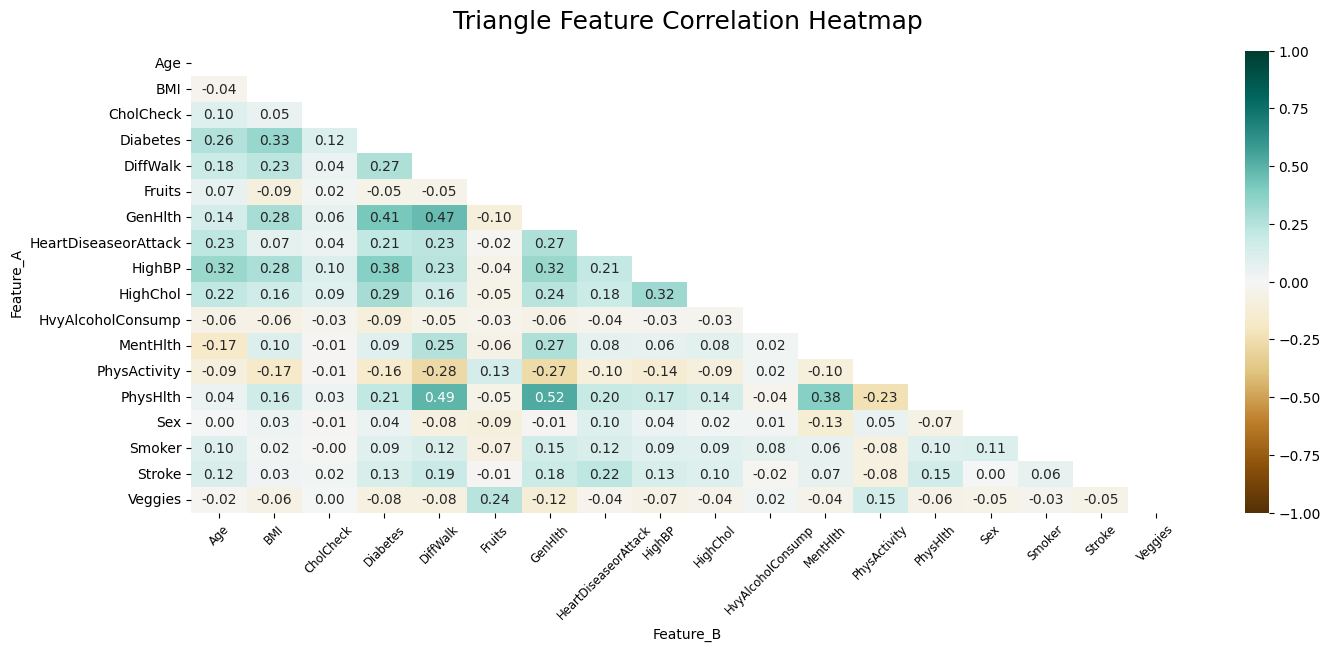

In [ ]:
correlation_matrix = corr_df.pivot_table(index='Feature_A', columns='Feature_B', values='Correlation')

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
heatmap = sns.heatmap(correlation_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt=".2f")
heatmap.set_title('Triangle Feature Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.xticks(rotation=45, size="small")

In [ ]:
corr_diabetes = corr_df[corr_df['Feature_A'] =='Diabetes'].drop('Feature_A', axis=1) # only include diabetes feature correlations
corr_diabetes = corr_diabetes[corr_diabetes['Feature_B'] !='Diabetes'] # drop diabetes-diabetes row
corr_diabetes["Correlation"] = corr_diabetes["Correlation"].abs() # get absolute value of correlations
corr_diabetes.sort_values(by='Correlation', ascending=False)

,Feature_B,Correlation
317,GenHlth,0.414259
322,HighBP,0.381516
310,BMI,0.328356
308,HighChol,0.289213
320,DiffWalk,0.272646
306,Age,0.261620
319,PhysHlth,0.215507
312,HeartDiseaseorAttack,0.211523
313,PhysActivity,0.158666
321,Stroke,0.125427


No feature has a >= 0.4 correlation with Diabetes status.

Text(0.5, 1.0, 'Distribution of Absolute Correlation Values with Diabetes')

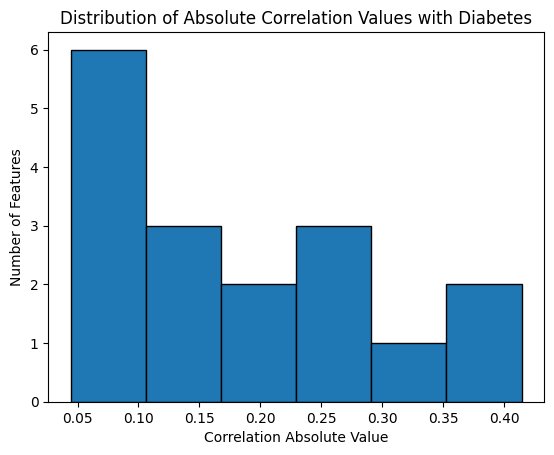

In [ ]:
# plot feature correlations
plt.hist(corr_diabetes["Correlation"], bins="auto", edgecolor='black')
plt.xlabel("Correlation Absolute Value")
plt.ylabel("Number of Features")
plt.title(f"Distribution of Absolute Correlation Values with Diabetes")

/tmp/ipython-input-2847171493.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=corr5_df['Feature_B'], x=corr5_df['Correlation'], palette="coolwarm", order=corr5_df["Feature_B"], )#, color=bar_colors)


<Figure size 1000x600 with 0 Axes>

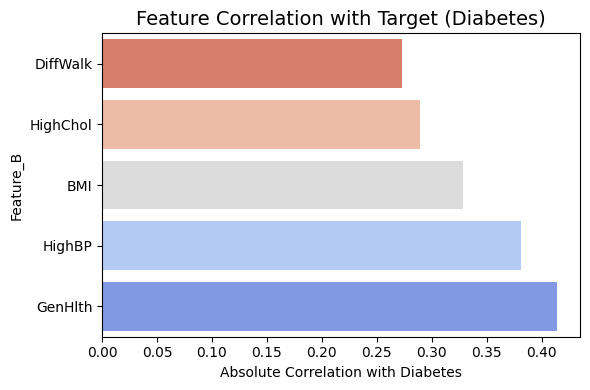

In [ ]:
# Top 5 Correlated Features
corr5_df = corr_df[1:6].sort_values(by='Correlation', ascending=False)
plt.figure(figsize=(10,6))

plt.figure(figsize=(6,4))
sns.barplot(y=corr5_df['Feature'], x=corr5_df['Correlation'], palette="coolwarm")
plt.xlabel("Absolute Correlation with Diabetes")
plt.title("Feature Correlation with Target (Diabetes)", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Removed Features*

In [9]:
removed_features = ["PhysHlth", "DiffWalk"]

# 4. Train / Test Data Split*

Split dataset into training & testing, features & target

In [39]:
X = df_raw.drop(['Diabetes'] + removed_features, axis=1)
y = df_raw['Diabetes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Model Development

### Basic Tryout of Various Algorithms

Notes
- make sure random_state = 42 always
- notice if the recall metrics are balanced. recall is more important than accuracy here

#### Logistical Regression

Basic Logistic Regression
- solver = "sag", "saga" apparently handle large datasets the best
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

In [11]:
scaler = StandardScaler()
scaler.fit(X.values)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lgr = LogisticRegression(solver="saga", max_iter=200)
lgr.fit(X_train, y_train)
y_pred = lgr.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[[5134 1936]
 [1662 5407]]
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74      7070
         1.0       0.74      0.76      0.75      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



Hyperparameter tuning

In [12]:
from sklearn.pipeline import Pipeline

# helps with catching diabetics more
recall_pos_scorer = make_scorer(recall_score, pos_label=1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver="saga",
        max_iter=200,
        n_jobs=-1
    ))
])


In [14]:
param_dist_lgr = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__C': np.logspace(-3, 1, 20),  # 0.001 to 10
    'logreg__l1_ratio': np.linspace(0.0, 1.0, 6)  # 0, 0.2, ..., 1.0
}

rand_lgr = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=param_dist_lgr,
    n_iter=25,
    scoring=recall_pos_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_lgr.fit(X_train, y_train)

print("Best RandomSearch params:", rand_lgr.best_params_)
print("Best CV score (recall class 1):", rand_lgr.best_score_)

best_lgr_rand = rand_lgr.best_estimator_
y_pred_lgr_rand = best_lgr_rand.predict(X_test)

print(confusion_matrix(y_test, y_pred_lgr_rand))
print(classification_report(y_test, y_pred_lgr_rand))


Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best RandomSearch params: {'logreg__penalty': 'l1', 'logreg__l1_ratio': np.float64(0.2), 'logreg__C': np.float64(0.004281332398719396)}
Best CV score (recall class 1): 0.7699190362385993
[[5131 1939]
 [1654 5415]]
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74      7070
         1.0       0.74      0.77      0.75      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



#### Basic K Nearest Neighbors
- n_neighbors is adjustable
- could try to see the optimal n

In [15]:
X= df_raw.drop('Diabetes', axis = 1)

In [33]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[4821 2249]
 [2020 5049]]
              precision    recall  f1-score   support

         0.0       0.70      0.68      0.69      7070
         1.0       0.69      0.71      0.70      7069

    accuracy                           0.70     14139
   macro avg       0.70      0.70      0.70     14139
weighted avg       0.70      0.70      0.70     14139



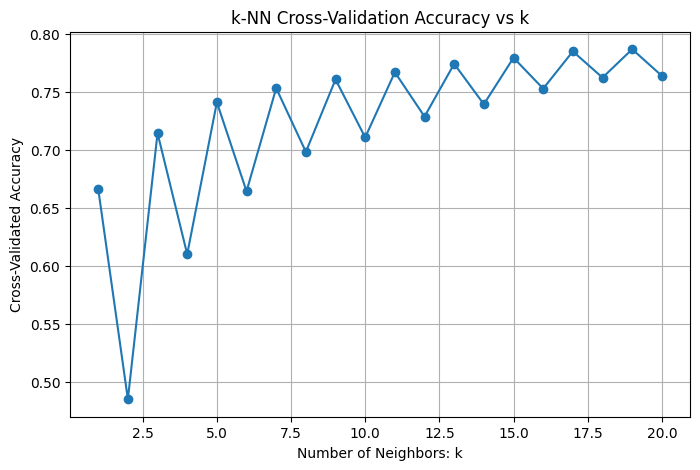

Best k from cross-validation: 11


In [32]:
# Range of k values to try
k_range = range(1, 21)
knn_scores = []

# Evaluate each k using 5-fold cross-validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = recall_score(y_test, y_pred, pos_label=1)
    knn_scores.append(score)

# Plot accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_range, knn_scores, marker='o')
plt.title("k-NN Cross-Validation Accuracy vs k")
plt.xlabel("Number of Neighbors: k")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)
plt.show()

# Best k
best_k = k_range[np.argmax(knn_scores)]
print(f"Best k from cross-validation: {best_k}")

In [35]:
best_knn = KNeighborsClassifier(n_neighbors=11)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[4855 2215]
 [1649 5420]]
              precision    recall  f1-score   support

         0.0       0.75      0.69      0.72      7070
         1.0       0.71      0.77      0.74      7069

    accuracy                           0.73     14139
   macro avg       0.73      0.73      0.73     14139
weighted avg       0.73      0.73      0.73     14139



#### Basic Decision Tree

In [ ]:
# Decision Tree model
dt = DecisionTreeClassifier(max_depth=None, random_state=42)
dt.fit(X_train, y_train)

# Predictions
y_pred = dt.predict(X_test)

# Results
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[4881 2189]
 [2603 4466]]
              precision    recall  f1-score   support

         0.0       0.65      0.69      0.67      7070
         1.0       0.67      0.63      0.65      7069

    accuracy                           0.66     14139
   macro avg       0.66      0.66      0.66     14139
weighted avg       0.66      0.66      0.66     14139



In [40]:
param_dist = {
    "max_depth": [3, None],
    "max_features": randint(1, 9),
    "min_samples_leaf": randint(1, 9),
    "criterion": ["gini", "entropy"]
}

dt = DecisionTreeClassifier()
dt_cv = RandomizedSearchCV(dt, param_dist, cv=5)
dt_cv.fit(X, y)

print("Tuned Decision Tree Parameters: {}".format(dt_cv.best_params_))
print("Best score is {}".format(dt_cv.best_score_))


print("Best RandomSearch params:", rand_lgr.best_params_)
print("Best CV score (recall class 1):", rand_lgr.best_score_)

best_dt = dt_cv.best_estimator_
y_pred = best_dt.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 8}
Best score is 0.7188367397795533
Best RandomSearch params: {'logreg__penalty': 'l1', 'logreg__l1_ratio': np.float64(0.2), 'logreg__C': np.float64(0.004281332398719396)}
Best CV score (recall class 1): 0.7699190362385993
[[5167 1903]
 [1654 5415]]
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74      7070
         1.0       0.74      0.77      0.75      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



### XGBoost

In [41]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[4948 2122]
 [1464 5605]]
              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73      7070
         1.0       0.73      0.79      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



#### Experimenting with scale_pos_weight & threshold changes

In [42]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    min_child_weight=5,
    scale_pos_weight=1.4 #affects false positives the most but gives more false positives and reduces true positives (range is 1.2-2.0)
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[4447 2623]
 [ 962 6107]]
              precision    recall  f1-score   support

         0.0       0.82      0.63      0.71      7070
         1.0       0.70      0.86      0.77      7069

    accuracy                           0.75     14139
   macro avg       0.76      0.75      0.74     14139
weighted avg       0.76      0.75      0.74     14139



Results so far with lower threshold --> gives least false negatives which is best for medical purposes

In [43]:
# Train the model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    max_depth=4,
    learning_rate=0.03,
    n_estimators=200,
    min_child_weight=7,
    colsample_bytree = 1,
    scale_pos_weight = 1.3
)
xgb_model.fit(X_train, y_train)

# Get predicted probabilities
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Lower threshold to reduce false negatives
threshold = 0.5 # try 0.45, 0.40, 0.35

y_pred_thresh = (y_proba >= threshold).astype(int)

print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh))


[[4532 2538]
 [1030 6039]]
              precision    recall  f1-score   support

         0.0       0.81      0.64      0.72      7070
         1.0       0.70      0.85      0.77      7069

    accuracy                           0.75     14139
   macro avg       0.76      0.75      0.74     14139
weighted avg       0.76      0.75      0.74     14139



#### Hyperparameter Tuning using RandomizedSearchCV

In [ ]:
xgb_base = xgb_model
param_dist_xgb = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.03, 0.05, 0.07],
    "n_estimators": [200, 300, 400],
    "min_child_weight": [3, 5, 7],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "scale_pos_weight": [1.0, 1.1, 1.2, 1.3]  # mild class weighting
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# optional: if you care more about catching diabetics (class 1)
recall_pos_scorer = make_scorer(recall_score, pos_label=1)

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=25,                    # increase if time
    scoring=recall_pos_scorer,    # optimize recall for diabetics
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

print("Best XGB params:", xgb_search.best_params_)
print("Best CV recall (class 1):", xgb_search.best_score_)
best_xgb = xgb_search.best_estimator_


##### Best XGBoost

Best XGBoost parameters:  
`'subsample': 1.0, 'scale_pos_weight': 1.3, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 1.0`




In [45]:
best_xgb = xgb.XGBClassifier(subsample=1.0, scale_pos_weight=1.3, n_estimators=200, min_child_weight=7, max_depth= 4, learning_rate= 0.03, colsample_bytree=1.0)

Best XGB Result

In [47]:
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost on test:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost on test:
[[4532 2538]
 [1030 6039]]
              precision    recall  f1-score   support

         0.0       0.81      0.64      0.72      7070
         1.0       0.70      0.85      0.77      7069

    accuracy                           0.75     14139
   macro avg       0.76      0.75      0.74     14139
weighted avg       0.76      0.75      0.74     14139



#### Threshold testing

threshold of 0.45-0.50 has the best balance of optimizing recall, but not letting nondiabetic recall fall too much

In [48]:
best_xgb.fit(X_train, y_train)
# Get predicted probabilities
y_proba = best_xgb.predict_proba(X_test)[:, 1]

for th in range(45, 55, 1):
    th /= 100
    y_pred = (y_proba >= th).astype(int)
    print("\nThreshold:", th)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits = 3))




Threshold: 0.45
[[4235 2835]
 [ 821 6248]]
              precision    recall  f1-score   support

         0.0      0.838     0.599     0.698      7070
         1.0      0.688     0.884     0.774      7069

    accuracy                          0.741     14139
   macro avg      0.763     0.741     0.736     14139
weighted avg      0.763     0.741     0.736     14139


Threshold: 0.46
[[4288 2782]
 [ 863 6206]]
              precision    recall  f1-score   support

         0.0      0.832     0.607     0.702      7070
         1.0      0.690     0.878     0.773      7069

    accuracy                          0.742     14139
   macro avg      0.761     0.742     0.737     14139
weighted avg      0.761     0.742     0.737     14139


Threshold: 0.47
[[4357 2713]
 [ 901 6168]]
              precision    recall  f1-score   support

         0.0      0.829     0.616     0.707      7070
         1.0      0.695     0.873     0.773      7069

    accuracy                          0.744     14

### Random Forest*

Basic Version

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
    )
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[4893 2177]
 [1821 5248]]
              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71      7070
         1.0       0.71      0.74      0.72      7069

    accuracy                           0.72     14139
   macro avg       0.72      0.72      0.72     14139
weighted avg       0.72      0.72      0.72     14139



#### Best RF*

In [62]:
best_rf = RandomForestClassifier(
    n_estimators=200,
   random_state=42,
   min_samples_split=10,
   min_samples_leaf=4,
   max_features='sqrt',
   max_depth=8,
   class_weight={0:1, 1:1.3}
)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[4426 2644]
 [1027 6042]]
              precision    recall  f1-score   support

         0.0      0.812     0.626     0.707      7070
         1.0      0.696     0.855     0.767      7069

    accuracy                          0.740     14139
   macro avg      0.754     0.740     0.737     14139
weighted avg      0.754     0.740     0.737     14139



Balanced version

In [63]:
rf = RandomForestClassifier(
    max_depth = 8,
    n_estimators = 100,
    min_samples_split = 5,
    min_samples_leaf = 2
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[4961 2109]
 [1480 5589]]
              precision    recall  f1-score   support

         0.0      0.770     0.702     0.734      7070
         1.0      0.726     0.791     0.757      7069

    accuracy                          0.746     14139
   macro avg      0.748     0.746     0.746     14139
weighted avg      0.748     0.746     0.746     14139



Hyperparameter Tuning Testing

In [ ]:
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    warm_start=True,
    max_samples=0.7
)

param_dist_rf = {
    "n_estimators": [150, 250],
    "max_depth": [None, 8],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"]
}

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=10,
    scoring=recall_pos_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train)


In [ ]:
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

param_dist_rf = {
    "n_estimators": [200, 300, 400],
    "max_depth": [None, 6, 8, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=25,
    scoring=recall_pos_scorer,   # tune for diabetic recall
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)
print("Best RF CV recall (class 1):", rf_search.best_score_)
best_rf = rf_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)
print("Random Forest on test:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Testing thresholds

In [64]:
# Fit tuned Random Forest
best_rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=8,
    class_weight={0:1, 1:1.3}
)
best_rf.fit(X_train, y_train)

# Get predicted probabilities
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Thresholds to test
thresholds = [0.40, 0.45, 0.50]

for th in thresholds:
    y_pred = (y_proba >= th).astype(int)
    print("\nThreshold:", th)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))



Threshold: 0.4
[[3637 3433]
 [ 545 6524]]
              precision    recall  f1-score   support

         0.0      0.870     0.514     0.646      7070
         1.0      0.655     0.923     0.766      7069

    accuracy                          0.719     14139
   macro avg      0.762     0.719     0.706     14139
weighted avg      0.762     0.719     0.706     14139


Threshold: 0.45
[[4011 3059]
 [ 750 6319]]
              precision    recall  f1-score   support

         0.0      0.842     0.567     0.678      7070
         1.0      0.674     0.894     0.768      7069

    accuracy                          0.731     14139
   macro avg      0.758     0.731     0.723     14139
weighted avg      0.758     0.731     0.723     14139


Threshold: 0.5
[[4426 2644]
 [1027 6042]]
              precision    recall  f1-score   support

         0.0      0.812     0.626     0.707      7070
         1.0      0.696     0.855     0.767      7069

    accuracy                          0.740     1413

### Voting Classifier

In [53]:
# Create different classifiers
# Create a list of labels for the classifiers
models = {'Logistic Regression': best_lgr_rand, 'Decision Tree': best_dt, 'KNN': best_knn, 'Random Forest': best_rf, 'XGBoost': best_xgb}

# Loop through the classifiers and perform 5-fold cross-validation for each
for label, clf in models.items():
    # Use cross_val_score to compute accuracy scores using 5-fold cross-validation
    scores = cross_val_score(clf, X, y,
                                              cv=5,
                                              scoring='accuracy')

    # Print the mean accuracy and standard deviation of accuracy for the current classifier
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Accuracy: 0.75 (+/- 0.00) [Logistic Regression]
Accuracy: 0.72 (+/- 0.01) [Decision Tree]
Accuracy: 0.71 (+/- 0.01) [KNN]
Accuracy: 0.74 (+/- 0.00) [Random Forest]
Accuracy: 0.75 (+/- 0.00) [XGBoost]


In [54]:
# Create a Hard Voting Classifier
voting_clf_hard = VotingClassifier(
    estimators=list(models.items()),
    voting='hard'  # Specify hard voting, where the majority class prediction is chosen
)

# Split into train and test
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

voting_clf_hard.fit(X_tr, y_tr)
pred_hard = voting_clf_hard.predict(X_te)

print("Hard Voting")
print("Accuracy :", accuracy_score(y_te, pred_hard))
print(confusion_matrix(y_te, pred_hard))
print(classification_report(y_te, pred_hard, digits=2))

print("Mean Squared Error :", mean_squared_error(y_te, pred_hard))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Hard Voting
Accuracy : 0.7455265577480727
[[4722 2348]
 [1250 5819]]
              precision    recall  f1-score   support

         0.0       0.79      0.67      0.72      7070
         1.0       0.71      0.82      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.74     14139
weighted avg       0.75      0.75      0.74     14139

Mean Squared Error : 0.2544734422519273


In [55]:
# Create a soft Voting Classifier
voting_clf_soft = VotingClassifier(
    estimators=list(models.items()),
    voting='soft'  # Specify soft voting, where class probabilities are combined
)

# Split into train and test
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

voting_clf_soft.fit(X_tr, y_tr)
pred_soft = voting_clf_soft.predict(X_te)
prob_soft = voting_clf_soft.predict_proba(X_te)[:,1]

print("\n=== Soft Voting  ===")
print("Accuracy :", accuracy_score(y_te, pred_soft))
print("ROC-AUC  :", roc_auc_score(y_te, prob_soft))
print(confusion_matrix(y_te, pred_soft))
print(classification_report(y_te, pred_soft, digits=2))

print("Mean Squared Error :", mean_squared_error(y_te, pred_soft))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(



=== Soft Voting  ===
Accuracy : 0.7457387368272155
ROC-AUC  : 0.8243329892474324
[[4825 2245]
 [1350 5719]]
              precision    recall  f1-score   support

         0.0       0.78      0.68      0.73      7070
         1.0       0.72      0.81      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.74     14139
weighted avg       0.75      0.75      0.74     14139

Mean Squared Error : 0.2542612631727845


# 6. Model Evaluation

## Model Testing

Male vs. Female Groups

In [ ]:
# Gender masks (0 = female, 1 = male)
male_mask = X_test["Sex"] == 1
female_mask = X_test["Sex"] == 0

X_test_male = X_test[male_mask]
y_test_male = y_test[male_mask]

X_test_female = X_test[female_mask]
y_test_female = y_test[female_mask]

print("Male test size:", X_test_male.shape[0])
print("Female test size:", X_test_female.shape[0])

# Evaluate random forest separately on males and females

# Males
y_pred_male = rf.predict(X_test_male)
print("\n=== Performance on MALE participants ===")
print(confusion_matrix(y_test_male, y_pred_male))
print(classification_report(y_test_male, y_pred_male, digits=3))

# Females
y_pred_female = rf.predict(X_test_female)
print("\n=== Performance on FEMALE participants ===")
print(confusion_matrix(y_test_female, y_pred_female))
print(classification_report(y_test_female, y_pred_female, digits=3))

# Quick summary
acc_male = accuracy_score(y_test_male, y_pred_male)
acc_female = accuracy_score(y_test_female, y_pred_female)
rec_male = recall_score(y_test_male, y_pred_male, pos_label=1)
rec_female = recall_score(y_test_female, y_pred_female, pos_label=1)

print(f"\nSummary:")
print(f"  Male   - accuracy: {acc_male:.3f}, diabetic recall: {rec_male:.3f}")
print(f"  Female - accuracy: {acc_female:.3f}, diabetic recall: {rec_female:.3f}")


Male test size: 6464
Female test size: 7675

=== Performance on MALE participants ===
[[1845 1249]
 [ 480 2890]]
              precision    recall  f1-score   support

         0.0      0.794     0.596     0.681      3094
         1.0      0.698     0.858     0.770      3370

    accuracy                          0.733      6464
   macro avg      0.746     0.727     0.725      6464
weighted avg      0.744     0.733     0.727      6464


=== Performance on FEMALE participants ===
[[2581 1395]
 [ 547 3152]]
              precision    recall  f1-score   support

         0.0      0.825     0.649     0.727      3976
         1.0      0.693     0.852     0.764      3699

    accuracy                          0.747      7675
   macro avg      0.759     0.751     0.746      7675
weighted avg      0.762     0.747     0.745      7675


Summary:
  Male   - accuracy: 0.733, diabetic recall: 0.858
  Female - accuracy: 0.747, diabetic recall: 0.852


Age Test

In [ ]:
# Define groups based on age feature (ordinal 1–13)
young_mask = X_test["Age"].isin([1, 2, 3, 4])
middle_mask = X_test["Age"].isin([5, 6, 7, 8])
older_mask = X_test["Age"].isin([9, 10, 11, 12, 13])

X_test_young = X_test[young_mask]
y_test_young = y_test[young_mask]

X_test_middle = X_test[middle_mask]
y_test_middle = y_test[middle_mask]

X_test_older = X_test[older_mask]
y_test_older = y_test[older_mask]

print("Young test size:", X_test_young.shape[0])
print("Middle-aged test size:", X_test_middle.shape[0])
print("Older adult test size:", X_test_older.shape[0])


# Young Adults
y_pred_young = rf.predict(X_test_young)
print("\nYOUNG adults")
print(confusion_matrix(y_test_young, y_pred_young))
print(classification_report(y_test_young, y_pred_young, digits=3))

acc_young = accuracy_score(y_test_young, y_pred_young)
rec_young = recall_score(y_test_young, y_pred_young, pos_label=1)

# Middle-Aged
y_pred_middle = rf.predict(X_test_middle)
print("\nMIDDLE-AGED adults")
print(confusion_matrix(y_test_middle, y_pred_middle))
print(classification_report(y_test_middle, y_pred_middle, digits=3))

acc_middle = accuracy_score(y_test_middle, y_pred_middle)
rec_middle = recall_score(y_test_middle, y_pred_middle, pos_label=1)

# Older Adults
y_pred_older = rf.predict(X_test_older)
print("\nOLDER adults")
print(confusion_matrix(y_test_older, y_pred_older))
print(classification_report(y_test_older, y_pred_older, digits=3))

acc_older = accuracy_score(y_test_older, y_pred_older)
rec_older = recall_score(y_test_older, y_pred_older, pos_label=1)

print("\n Summary")
print(f"Young adults     — accuracy: {acc_young:.3f}, diabetic recall: {rec_young:.3f}")
print(f"Middle-aged      — accuracy: {acc_middle:.3f}, diabetic recall: {rec_middle:.3f}")
print(f"Older adults     — accuracy: {acc_older:.3f}, diabetic recall: {rec_older:.3f}")


Young test size: 1486
Middle-aged test size: 4665
Older adult test size: 7988

=== Performance on YOUNG adults ===
[[1138   97]
 [ 123  128]]
              precision    recall  f1-score   support

         0.0      0.902     0.921     0.912      1235
         1.0      0.569     0.510     0.538       251

    accuracy                          0.852      1486
   macro avg      0.736     0.716     0.725      1486
weighted avg      0.846     0.852     0.849      1486


=== Performance on MIDDLE-AGED adults ===
[[1830  832]
 [ 371 1632]]
              precision    recall  f1-score   support

         0.0      0.831     0.687     0.753      2662
         1.0      0.662     0.815     0.731      2003

    accuracy                          0.742      4665
   macro avg      0.747     0.751     0.742      4665
weighted avg      0.759     0.742     0.743      4665


=== Performance on OLDER adults ===
[[1458 1715]
 [ 533 4282]]
              precision    recall  f1-score   support

         0.0   

## Feature Analysis

#### LOFO (Leave-One-Feature-Out): Accuracy & Recall Removing 1 feature at a time (XGBoost)

This is XGBoost when removing one feature at a time

In [ ]:
from tqdm.auto import tqdm
def train_model(X_train, y_train):
    # Use your tuned hyperparameters here
    return best_xgb.fit(X_train, y_train)

def lofo_recall_drops(X: pd.DataFrame, y: pd.Series, pos_label=1):
    # base model (all features)
    base = train_model(X_train, y_train)
    base_preds = base.predict(X_test)
    base_recall_pos = recall_score(y_test, base_preds, pos_label=pos_label)
    base_recall_neg = recall_score(y_test, base_preds, pos_label=0)

    drops = {}
    for feat in tqdm(X.columns, desc="LOFO"):
        # train WITHOUT this feature
        model_sub = train_model(X_train.drop(columns=[feat]), y_train)
        preds_sub = model_sub.predict(X_test.drop(columns=[feat]))

        r_pos = recall_score(y_test, preds_sub, pos_label=pos_label)
        r_neg = recall_score(y_test, preds_sub, pos_label=0)

        # positive value = feature *helps* recall of that class (base - without)
        drops[feat] = {
            "delta_recall_pos": base_recall_pos - r_pos,
            "delta_recall_neg": base_recall_neg - r_neg,
            "recall_pos_without": r_pos,
            "recall_neg_without": r_neg
        }

    # return sorted by biggest positive-class recall drop
    sorted_feats = dict(sorted(drops.items(), key=lambda kv: kv[1]["delta_recall_pos"], reverse=True))
    return {"base_recall_pos": base_recall_pos, "base_recall_neg": base_recall_neg, "drops": sorted_feats}

In [ ]:
res = lofo_recall_drops(X, y, pos_label=1)
print("Base diabetic recall:", res["base_recall_pos"])
# top features that hurt recall most when removed:

lofo_recall_scores = []

for feat, stats in list(res["drops"].items()):
    print(feat, stats["delta_recall_pos"])
    lofo_recall_scores.append((feat, stats["delta_recall_pos"]))

LOFO:   0%|          | 0/15 [00:00<?, ?it/s]

Base diabetic recall: 0.8542933936907625
Age 0.018248691469797684
GenHlth 0.01640967605036081
HighChol 0.006365822605743365
HighBP 0.006365822605743365
HvyAlcoholConsump 0.0031121799405856576
Sex 0.0026877917668695073
CholCheck 0.002121940868581196
HeartDiseaseorAttack 0.0008487763474325227
PhysActivity 0.0007073136228603616
Smoker 0.0005658508982883115
MentHlth 0.0005658508982883115
BMI 0.00042438817371626136
Veggies -0.00014146272457205011
Stroke -0.00014146272457205011
Fruits -0.00042438817371615034


In [ ]:
scores = cross_validate(best_xgb, X, y, cv=5, scoring=('accuracy','recall'))
cv_accuracy_scores = [scores['test_accuracy'].mean()]
cv_recall_scores = [scores['test_recall'].mean()]

for i in X_train.columns:
    X_temp = X.drop(i, axis=1)

    # Cross-validation on X_temp and y
    scores = cross_validate(xgb_model, X_temp, y, cv=5, scoring=('accuracy','recall'))

    cv_accuracy_scores.append(scores['test_accuracy'].mean())
    cv_recall_scores.append(scores['test_recall'].mean())

Accuracy Plot for every dropped feature

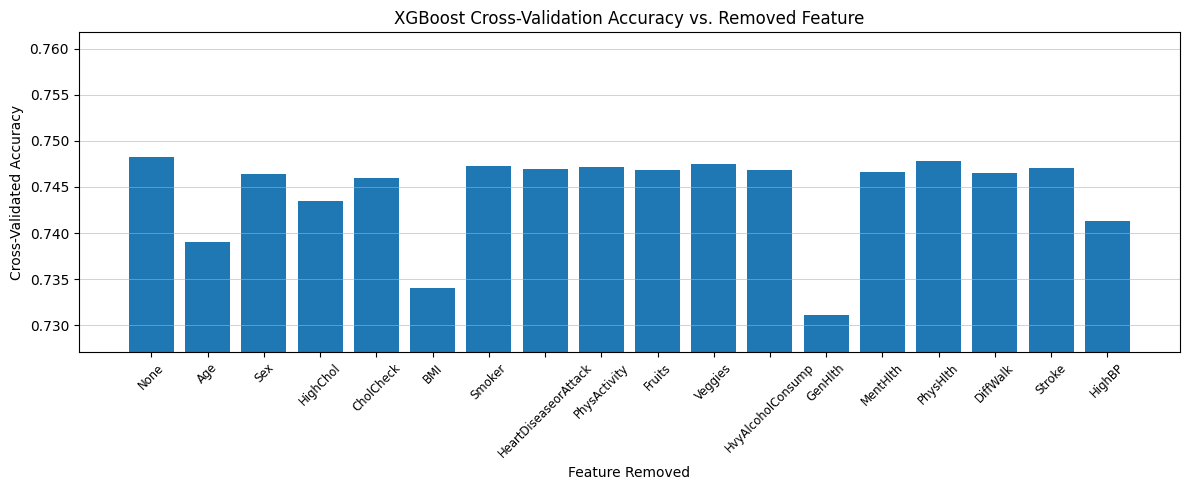

In [ ]:
low = stats.mean(cv_accuracy_scores) - stats.stdev(cv_accuracy_scores)*3.5
high = stats.mean(cv_accuracy_scores) + stats.stdev(cv_accuracy_scores)*3.5

# Plot accuracy vs. removed feature
plt.figure(figsize=(12, 5))
plt.bar(["None"] + list(X_train.columns), cv_accuracy_scores)
plt.title("XGBoost Cross-Validation Accuracy vs. Removed Feature")
plt.xlabel("Feature Removed")
plt.ylabel("Cross-Validated Accuracy")
plt.xticks(rotation=45, size="small") # Rotate x-axis labels for better readability
plt.ylim([low, high])
plt.grid(True, axis='y',linewidth=.4)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

Recall Plot for every dropped feature

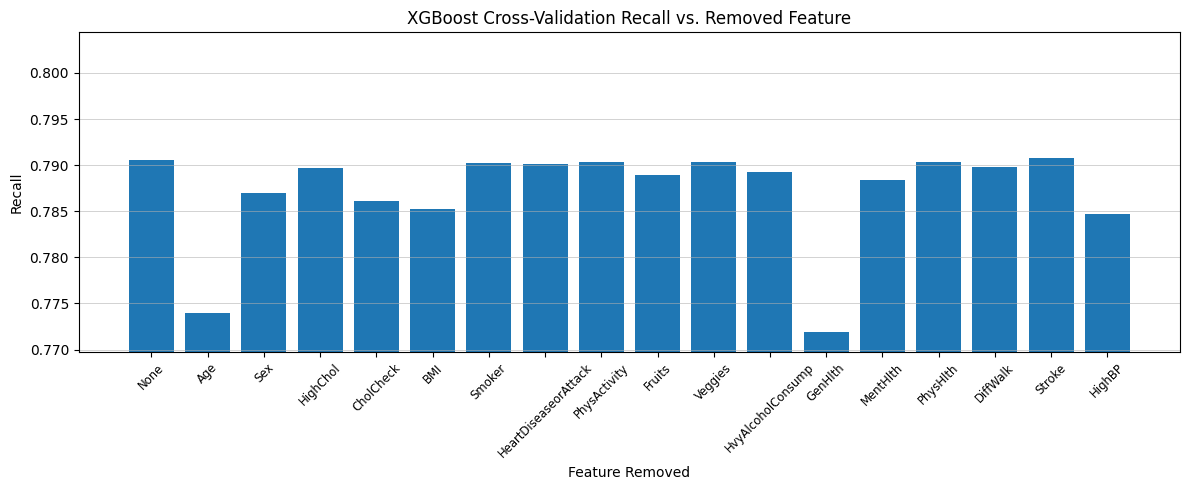

In [ ]:
# Plot recall vs. removed feature
low = stats.mean(cv_recall_scores) - stats.stdev(cv_accuracy_scores)*3.5
high = stats.mean(cv_recall_scores) + stats.stdev(cv_accuracy_scores)*3.5

# Plot accuracy vs. removed feature
plt.figure(figsize=(12, 5))
plt.bar(["None"] + list(X_train.columns), cv_recall_scores)
plt.title("XGBoost Cross-Validation Recall vs. Removed Feature")
plt.xlabel("Feature Removed")
plt.ylabel("Recall")
plt.xticks(rotation=45, size="small") # Rotate x-axis labels for better readability
plt.ylim([low, high])
plt.grid(True, axis='y',linewidth=.4)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

#### Permutation Importance using XGBoost

Basic XGBoost

In [ ]:
best_xgb.fit(X_train, y_train)
result = permutation_importance(best_xgb, X, y, n_repeats=17)

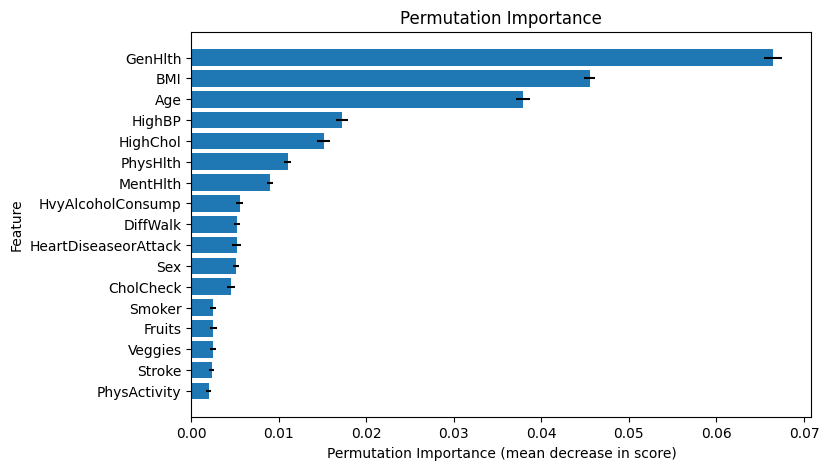

In [ ]:
means = result.importances_mean
stds = result.importances_std
features = X.columns

idx = np.argsort(means)  # sort low → high

plt.figure(figsize=(8,5))
plt.barh(features[idx], means[idx], xerr=stds[idx])
plt.xlabel("Permutation Importance (mean decrease in score)")
plt.ylabel("Feature")
plt.title("Permutation Importance")
plt.show()

In [ ]:
X_less = df_raw[['Age','HighChol','GenHlth', 'HighBP', "BMI", "HvyAlcoholConsump", 'CholCheck', "Sex","Veggies"]]

X_train, X_test, y_train, y_test = train_test_split(
    X_less, y, test_size=0.2, stratify=y, random_state=42
)
xgb_base.fit(X_train, y_train)
y_pred = xgb_base.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits = 3))

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits = 3))

[[4934 2136]
 [1455 5614]]
              precision    recall  f1-score   support

         0.0      0.772     0.698     0.733      7070
         1.0      0.724     0.794     0.758      7069

    accuracy                          0.746     14139
   macro avg      0.748     0.746     0.745     14139
weighted avg      0.748     0.746     0.745     14139

[[4509 2561]
 [1039 6030]]
              precision    recall  f1-score   support

         0.0      0.813     0.638     0.715      7070
         1.0      0.702     0.853     0.770      7069

    accuracy                          0.745     14139
   macro avg      0.757     0.745     0.742     14139
weighted avg      0.757     0.745     0.742     14139



In [ ]:
X_less = df_raw.drop(['MentHlth','PhysHlth'], axis = 1)
X_less

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,6.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0
70688,10.0,1.0,1.0,1.0,29.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0
70689,13.0,0.0,1.0,1.0,25.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0,1.0
70690,11.0,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,1.0


In [ ]:
X_less = df_raw.drop(['DiffWalk','PhysHlth','Diabetes'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
xgb_base.fit(X_train, y_train)
y_pred = xgb_base.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits = 3))

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits = 3))

[[4966 2104]
 [1481 5588]]
              precision    recall  f1-score   support

         0.0      0.770     0.702     0.735      7070
         1.0      0.726     0.790     0.757      7069

    accuracy                          0.746     14139
   macro avg      0.748     0.746     0.746     14139
weighted avg      0.748     0.746     0.746     14139

[[4541 2529]
 [1036 6033]]
              precision    recall  f1-score   support

         0.0      0.814     0.642     0.718      7070
         1.0      0.705     0.853     0.772      7069

    accuracy                          0.748     14139
   macro avg      0.759     0.748     0.745     14139
weighted avg      0.759     0.748     0.745     14139



In [ ]:
X_less = df_raw.drop(['PhysHlth','Diabetes','Fruits', "PhysActivity", "Stroke", "DiffWalk", "Smoker"], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
xgb_base.fit(X_train, y_train)
y_pred = xgb_base.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits = 3))

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits = 3))

[[4966 2104]
 [1481 5588]]
              precision    recall  f1-score   support

         0.0      0.770     0.702     0.735      7070
         1.0      0.726     0.790     0.757      7069

    accuracy                          0.746     14139
   macro avg      0.748     0.746     0.746     14139
weighted avg      0.748     0.746     0.746     14139

[[4541 2529]
 [1036 6033]]
              precision    recall  f1-score   support

         0.0      0.814     0.642     0.718      7070
         1.0      0.705     0.853     0.772      7069

    accuracy                          0.748     14139
   macro avg      0.759     0.748     0.745     14139
weighted avg      0.759     0.748     0.745     14139



In [ ]:
model = xgb_model
probs = model.predict_proba(X_test)[:, 1]  # probability for diabetic
thresholds = np.linspace(0, 1, 101)      # 0.00, 0.01, ..., 1.00

best_thresh = 0.5
best_diag_recall = 0
min_nondiag_recall = 0.64

for t in thresholds:
    preds = (probs >= t).astype(int)
    diag_recall = recall_score(y_test, preds, pos_label=1)
    nondiag_recall = recall_score(y_test, preds, pos_label=0)

    # keep threshold if diabetic recall improves and nondiabetic recall above minimum
    if diag_recall > best_diag_recall and nondiag_recall >= min_nondiag_recall:
        best_diag_recall = diag_recall
        best_thresh = t
        best_nondiag_recall = nondiag_recall

print(f"Optimal threshold: {best_thresh:.2f}")
print(f"Diabetic recall: {best_diag_recall:.3f}")
print(f"Nondiabetic recall: {best_nondiag_recall:.3f}")

Optimal threshold: 0.50
Diabetic recall: 0.849
Nondiabetic recall: 0.642


In [ ]:
n_splits = 5  # 5-fold CV
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

diabetic_recalls = []
nondiabetic_recalls = []

for train_idx, val_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)

    # Predict probabilities
    probs = model.predict_proba(X_test)[:,1]

    # Apply threshold (e.g., best_thresh from previous tuning)
    preds = (probs >= 0.5).astype(int)

    # Compute recalls
    diabetic_recalls.append(recall_score(y_test, preds, pos_label=1))
    nondiabetic_recalls.append(recall_score(y_test, preds, pos_label=0))

print(f"Diabetic recall: mean={np.mean(diabetic_recalls):.3f}, std={np.std(diabetic_recalls):.3f}")
print(f"Nondiabetic recall: mean={np.mean(nondiabetic_recalls):.3f}, std={np.std(nondiabetic_recalls):.3f}")


Diabetic recall: mean=0.852, std=0.002
Nondiabetic recall: mean=0.644, std=0.005


In [ ]:
xgb_model = xgb.XGBClassifier(subsample = 1.0, scale_pos_weight = 1.3, n_estimators = 200,min_child_weight =7, max_depth =  4, learning_rate =  0.03, colsample_bytree = 1.0)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits = 3))


[[4498 2572]
 [1079 5990]]
              precision    recall  f1-score   support

         0.0      0.807     0.636     0.711      7070
         1.0      0.700     0.847     0.766      7069

    accuracy                          0.742     14139
   macro avg      0.753     0.742     0.739     14139
weighted avg      0.753     0.742     0.739     14139



#### Recursive Feature Elimination: Find Optimal Number of Features using XGBoost

could tend to overfit

In [ ]:
min_features_to_select = 1  # Minimum number of features to consider
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=best_xgb,
    step=1,
    cv=cv,
    scoring="recall",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X, y)

print("Optimal number of features:", rfecv.n_features_)
print("Feature ranking:", rfecv.ranking_)
print(X.columns)

In [ ]:
rankings = [(X.columns[i], int(rfecv.ranking_[i])) for i in range(len(rfecv.ranking_))]
rankings.sort(key=operator.itemgetter(1))
rankings

[('Age', 1),
 ('HighChol', 1),
 ('GenHlth', 1),
 ('HighBP', 1),
 ('DiffWalk', 2),
 ('BMI', 3),
 ('HeartDiseaseorAttack', 4),
 ('CholCheck', 5),
 ('HvyAlcoholConsump', 6),
 ('Sex', 7),
 ('Stroke', 8),
 ('Veggies', 9),
 ('MentHlth', 10),
 ('PhysHlth', 11),
 ('PhysActivity', 12),
 ('Smoker', 13),
 ('Fruits', 14)]

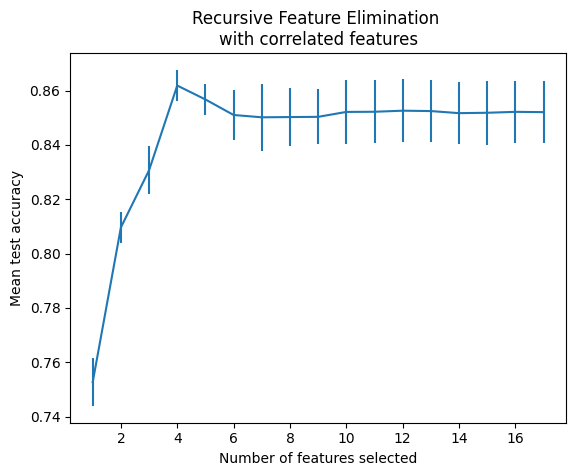

In [ ]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

#### ROC-AUC Curve

done for random forest

In [67]:
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

[[4426 2644]
 [1027 6042]]
              precision    recall  f1-score   support

         0.0       0.81      0.63      0.71      7070
         1.0       0.70      0.85      0.77      7069

    accuracy                           0.74     14139
   macro avg       0.75      0.74      0.74     14139
weighted avg       0.75      0.74      0.74     14139



In [68]:
test_df = pd.DataFrame(
    {'True': y_test, 'RandomForest': y_pred_rf})
test_df

,True,RandomForest
57608,1.0,1.0
18474,0.0,1.0
47268,1.0,1.0
31419,0.0,0.0
56545,1.0,1.0
...,...,...
14537,0.0,0.0
13704,0.0,0.0
62461,1.0,1.0
70180,1.0,1.0


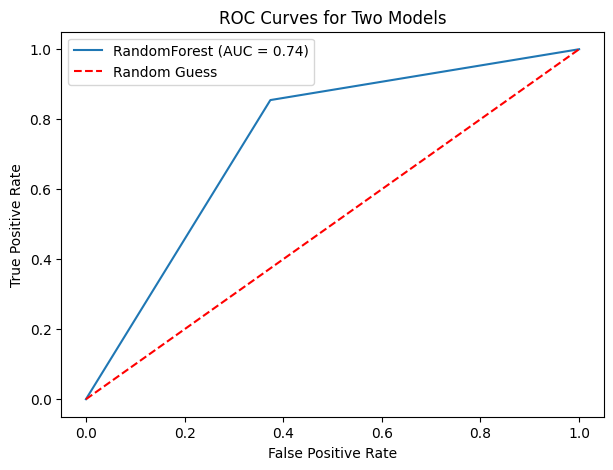

In [69]:
plt.figure(figsize=(7, 5))

fpr, tpr, _ = roc_curve(test_df['True'], test_df['RandomForest'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{'RandomForest'} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

### SHAP Feature Importance

done for XGBoost

In [58]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_importance)

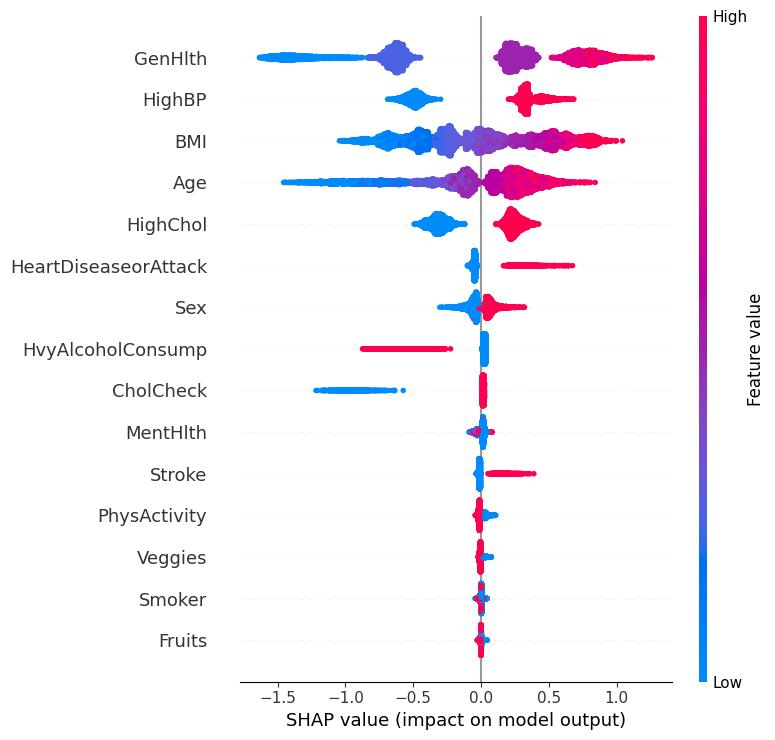

In [59]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

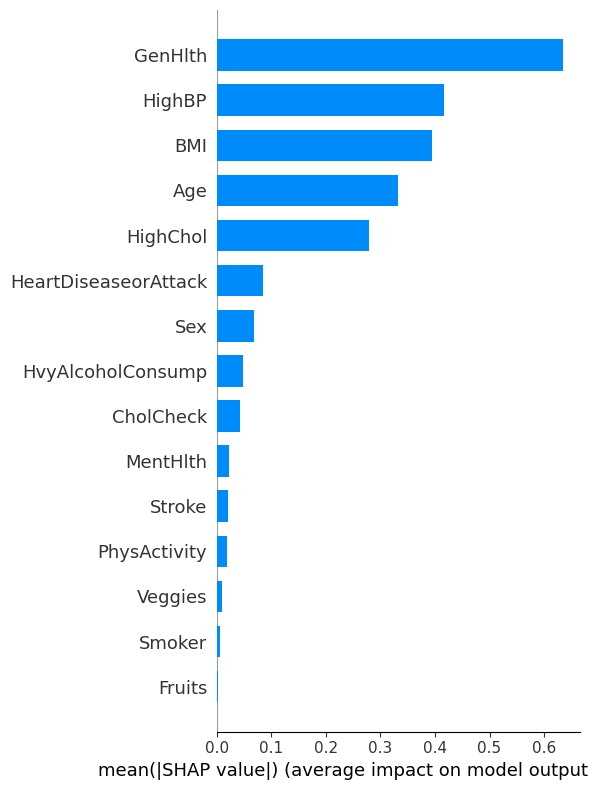

In [60]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar', plot_size=[6,8])